In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [49]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

In [164]:
import pandas as pd

from imblearn import pipeline
from imblearn import over_sampling

from sklearn.metrics import accuracy_score, precision_recall_curve, f1_score, roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [14]:
def get_balanced_dataset():
    train_matches = pd.read_csv('train.csv')
    gold = pd.read_csv('gold.csv')
    gold = gold[gold.times == 600]
    radiant_gold = gold[['player_0', 'player_1', 'player_2', 'player_3', 'player_4']].sum(axis=1)
    dire_gold = gold[['player_5', 'player_6', 'player_7', 'player_8', 'player_9']].sum(axis=1)

    gold['radiant_gold'] = radiant_gold
    gold['dire_gold'] = dire_gold
    gold['diff_gold'] = gold['radiant_gold'] - gold['dire_gold']
    gold['ratio_gold'] = gold['radiant_gold'] / gold['dire_gold']
    train = pd.merge(train_matches[['mid']], gold, on='mid', how='left').drop(['mid', 'times'], 1)
    x = train.values
    y = train_matches.radiant_won.values
    return x, y

def get_unbalanced_dataset():
    df = pd.read_csv('nursery.csv')
    dummies = []
    for c in df.columns.difference(['class']):
        dummies.append(pd.get_dummies(df[c]))
    x = np.hstack(dummies)
    y = (df['class'] == 'very_recom').astype(np.int)
    return x, y

In [15]:
x_balanced, y_balanced = get_balanced_dataset()
x_unbalanced, y_unbalanced = get_unbalanced_dataset()

In [16]:
print(np.mean(y_balanced))
print(np.mean(y_unbalanced))

0.519500280292
0.0253086419753


# Метрики и несбалансированные выборки

### 04.04.2017

#### Мельник Богдан

## Метрики и задачи связаны

* Регрессия
* Классификация
* Временные ряды
* Ранжирование

## Метрики регрессии
### Mean squared error 

$$MSE = \frac{1}{l} \sum_{i = 1}^{l}{(a(x_i) - y_i)^2}$$

* Во многих библиотеках для регрессии является метрикой по умолчанию 
* Иногда используется $RMSE = \sqrt{MSE}$ для получения ошибки такой же размерности, что и у таргета
* Штрафует большие ошибки сильней, чем маленькие

## Mean absolute error

$$MAE = \frac{1}{l} \sum_{i = 1}^{l}{\left| a(x_i) - y_i \right|}$$

* Иногда используется вместо $MSE$ из-за большей устойчивости к выбросам
* Интуитивно понятна

## Сравнение MSE и MAE

![](https://cdn-images-1.medium.com/max/800/1*YTxb8K2XZIisC944v6rERw.png)

## Недостатки MSE и MAE 

* MSE и MAE позволяет сравнивать качество моделей между собой
* Даёт плохое представление о том насколько хорошо решена задача
* Решение с $MSE = 10$ может быть плохим, если $y \in (0, \dots, 10)$, или хорошим, если $y \in (1000, \dots, 10000)$

## Коэффициент детерминации

$$R^2 = 1 - \frac{\sum_{i = 1}^{l}{(a(x_i) - y_i)^2}}{\sum_{i = 1}^{l}{(\bar{y} - y_i)^2}}$$

* Позволяет получить нормированную оценку качества
* Измеряет долю дисперсии, объясненную моделью, и имеет значение от $0$ до $1$
* Если значение близко к $1$ — модель полностью объясняет дисперсию $y$
* Если значение близко к $0$ — модель сопоставима по качеству со средним предсказанием

## Метрики классификации
### Матрица ошибок

|                    |        y = 1        |        y = 0        |
|:------------------:|:-------------------:|:-------------------:|
| **a(x) = 1**         |  True Positive (TP) | False Positive (FP) |
| **a(x) = 0**         | False Negative (FN) |  True Negative (TN) |

* Используется для вывода многих метрик для задач классификации

## Accuracy

$$acuraccy = \frac{1}{l} \sum_{i = 1}^{l}{[a(x_i) = y_i]} \\ acuraccy = \frac{TP + TN}{TP + FN + FP + TN}$$

* Доля правильных ответов классификатора
* Самый простой способ оценить качество классификации
* Вычисляется по умолчанию при использовании ```cross_val_score``` в задачах классификации
* Плохо работает, если классы несбалансированы

In [20]:
print(accuracy_score(y_balanced, np.zeros_like(y_balanced)))
print(accuracy_score(y_unbalanced, np.zeros_like(y_unbalanced)))

0.480499719708
0.974691358025


## Точность и полнота

$$precision = \frac{TP}{TP + FP} \\ recall = \frac{TP}{TP + FN}$$

* Точность показывает какая доля объектов, выделенная классификатором как положительная, действительно является положительной
* Полнота показывает какая доля положительных объектов была выделена классификатором как положительная
* Если $a(x) = [p(x) > t]$, то обычно при увеличении $t$ точность будет расти, а полнота падать

In [222]:
y_hat = cross_val_predict(LogisticRegression(), x_balanced, y_balanced, cv=5, method='predict_proba')[:, 1]

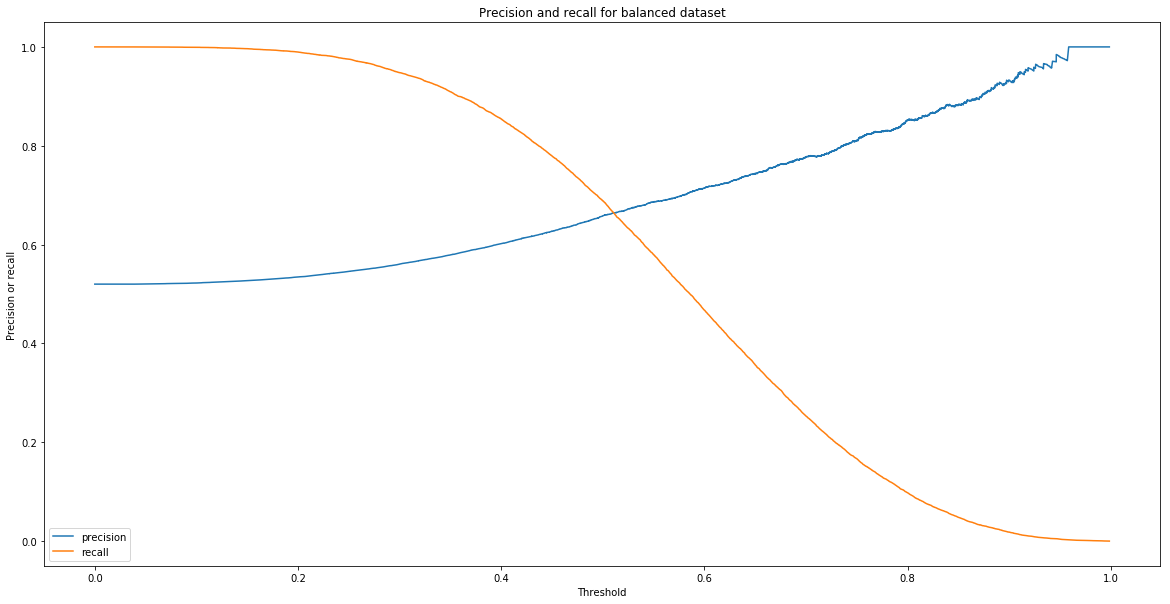

In [225]:
precision, recall, thresholds = precision_recall_curve(y_balanced, y_hat)
thresholds = [0] + thresholds.tolist()
plot(thresholds, precision, label='precision');
plot(thresholds, recall, label='recall');
legend(); xlabel('Threshold'); ylabel('Precision or recall');
title('Precision and recall for balanced dataset');

## F-score

$$F = \frac{2 * precision * recall}{precision + recall}$$

* Способ объеденить точность и полноту в одной метрике
* Принимает значения от $0$ до $1$
* Точность, полнота и F-score подходят для оценки качества на несбалансированных выборках
* Необходимо выбирать порог $t$ в случае вещественного ответа $p(x)$

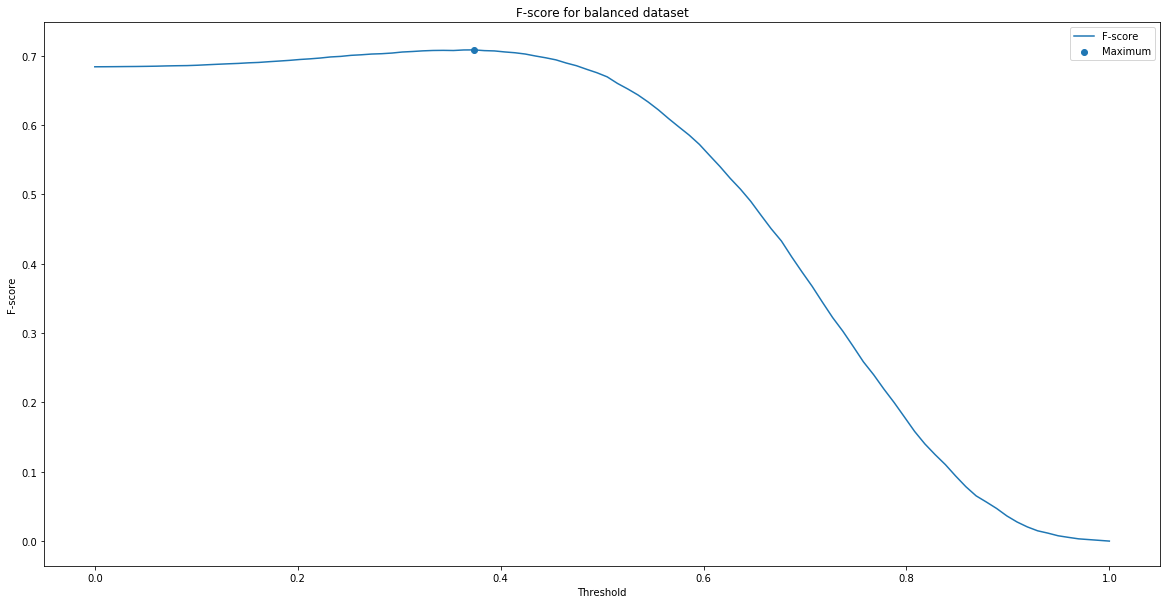

In [224]:
thresholds = np.linspace(0, 1, 100)
scores = [f1_score(y_balanced, (y_hat > t).astype(np.int)) for t in thresholds]
plot(thresholds, scores, label='F-score');
scatter(thresholds[np.argmax(scores)], np.max(scores), label='Maximum');
legend(); xlabel('Threshold'); ylabel('F-score');
title('F-score for balanced dataset');

## ROC AUC

* Способ оценки качества классификации без необходимости подбора порога

In [63]:
roc_auc_score(y_balanced, y_hat)

0.70524418709213299

## ROC AUC

* Использует только порядок ответов, соответственно любое монотонное преобразование не меняет значение метрики

In [64]:
print(roc_auc_score(y_balanced, y_hat))
print(roc_auc_score(y_balanced, 100 * y_hat + 5))
print(roc_auc_score(y_balanced, y_hat ** 2))

0.705244187092
0.705244187092
0.705244187092


## ROC AUC

* Для модели возвращающей случайную вероятность $AUC = 0.5$

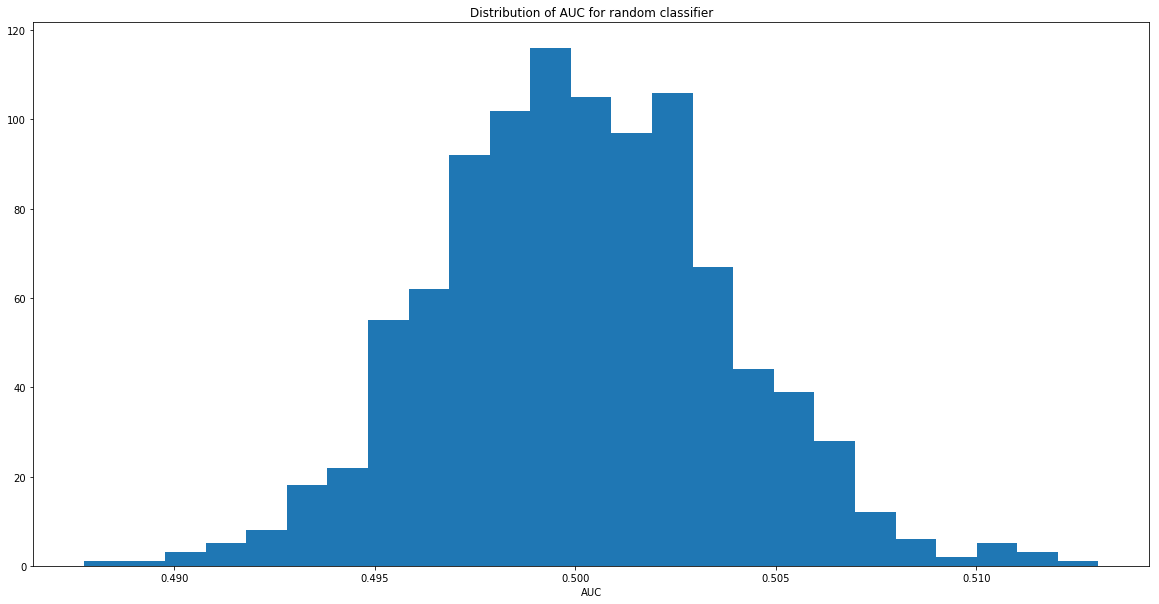

In [228]:
hist([roc_auc_score(y_balanced, np.random.random(size=y_balanced.shape[0])) for i in range(1000)], bins=25);
xlabel('AUC');
title('Distribution of AUC for random classifier');

## ROC AUC

* Имеет несколько интерпретаций
    * Площадь под кривой изображающую зависимость $TPR = \frac{TP}{TP+FN}$ от $FPR = \frac{TN}{TN+FP}$
    * Вероятность $p(x_1) < p(x_2)$ для двух случайных объектов, у которых $y_1 = 0$ и $y_2 = 1$
    * Зависит от доли дефектных пар

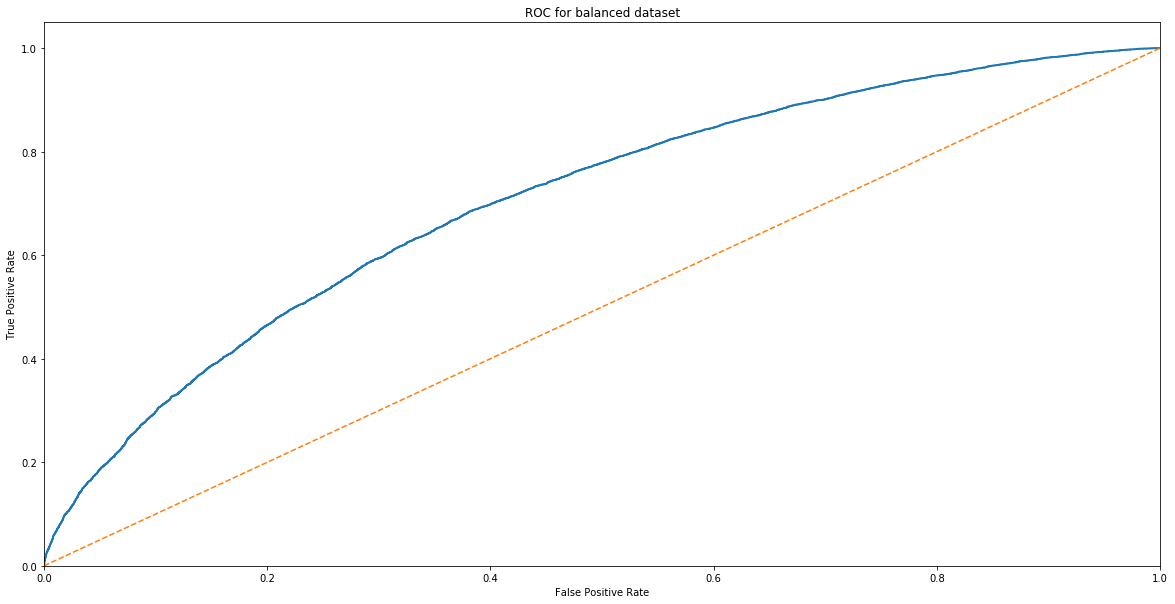

In [227]:
fpr, tpr, _ = roc_curve(y_balanced, y_hat)
plot(fpr, tpr, lw=2);
plot([0, 1], [0, 1], linestyle='--');
xlim([0.0, 1.0]); ylim([0.0, 1.05]);
xlabel('False Positive Rate'); ylabel('True Positive Rate');
title('ROC for balanced dataset');

## ROC AUC

* Также как и $accuracy$ неинформативен в случае несбалансированных выборок, но при этом лучше ведёт себя, если передать в качестве ответов метки доминирующего класса

In [95]:
print(np.mean(cross_val_score(LogisticRegression(), x_unbalanced, y_unbalanced, cv=StratifiedKFold(10))))
print(roc_auc_score(y_unbalanced, np.zeros_like(y_unbalanced)))

0.9771648334
0.5


## Logloss

$$logloss = \sum_{i = 1}^{l}{y_i * \log( p(x_i) ) + (1 - y_i) * log(1 - p(x_i))}$$

* Логарифм вероятности получить исходный вектор ответов
* В отличие от **ROC AUC** важны значения, а не порядок

## Logloss

* Одно близкое к нулю значение под логарифмом может сильно испортить всю метрику

In [113]:
log_loss(y_balanced, y_hat, eps=0)

0.62378626588930719

In [114]:
y_hat[0] = 1 - y_balanced[0]
log_loss(y_balanced, y_hat, eps=0)

inf

## Больше метрик

* Существует огромное количество других метрик
* Зачастую специфичны для определённого круга задач
* Описание некоторых других метрик на [Kaggle](https://www.kaggle.com/wiki/Metrics) 

## Работа с несбалансированными выборками

* Можно считать, что выборка несбалансирована, когда размеры классов отличаются более, чем в 10 раз
* Больший класс называют доминирующим, меньший класс называется минорным
* Зачастую можно повысить качество с помощью
    * Корректировки весов объектов
    * Исскуственной модификации датасета

In [116]:
np.mean(y_unbalanced)

0.025308641975308643

In [117]:
cv = StratifiedKFold(n_splits=20)

## Оценка качества при несбалансированных выборках

* **Accuracy** и **AUC** дают близкие к $1$ значения, которые слабо меняются при изменении модели
* **F-score** гораздо более чувствительна к изменениям модели



In [120]:
print(np.mean(cross_val_score(LogisticRegression(), x_unbalanced, y_unbalanced, cv=cv, scoring='accuracy')))
print(np.mean(cross_val_score(LogisticRegression(), x_unbalanced, y_unbalanced, cv=cv, scoring='roc_auc')))

0.981562067774
0.993632917551


In [121]:
np.mean(cross_val_score(LogisticRegression(), x_unbalanced, y_unbalanced, cv=cv, scoring='f1'))

0.63985523564465452

In [143]:
y_hat = cross_val_predict(LogisticRegression(), x_unbalanced, y_unbalanced, cv=cv, method='predict_proba')[:, 1]

In [124]:
def get_score(alpha, y, y_hat):
    return f1_score(y, (y_hat > alpha).astype('int'))

## Подбор порога без изменений в обучении

* Подберём порог для **F-score**
* Лучший $F = 0.676510$ при $\alpha = 0.356783$

In [144]:
alphas = np.linspace(0, 1, 200)
scores = [get_score(alpha, y_unbalanced, y_hat) for alpha in alphas]

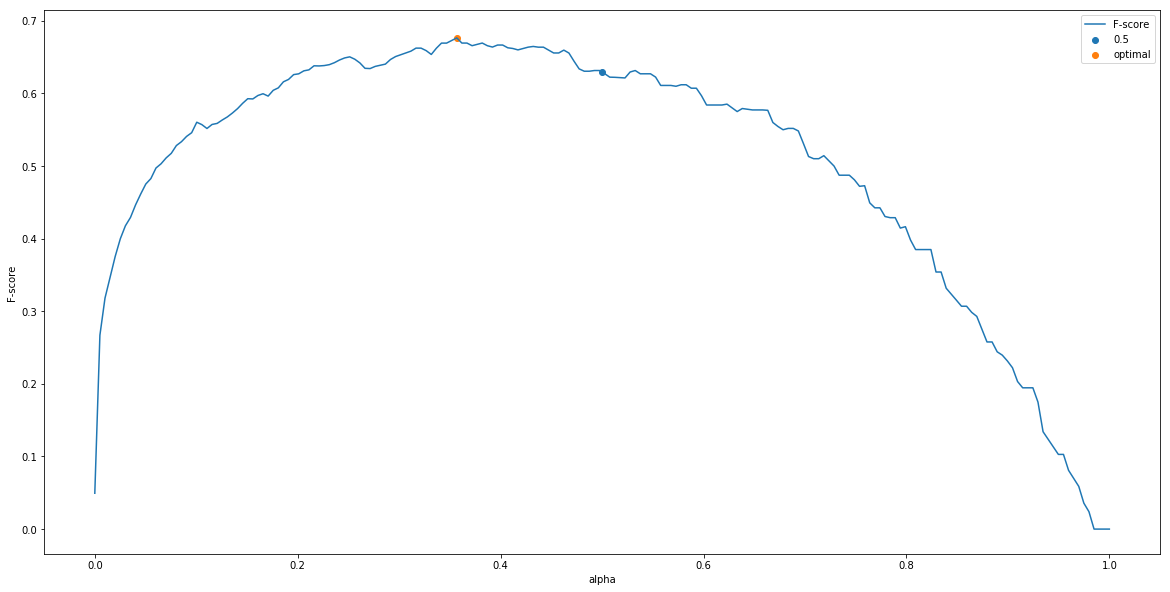

In [145]:
plot(alphas, scores, label='F-score');
scatter(0.5, get_score(0.5, y_unbalanced, y_hat), label='0.5');
scatter(alphas[np.argmax(scores)], np.max(scores), label='optimal');
xlabel('alpha'); ylabel('F-score'); legend();

## Корректировка весов

* Большинство моделей в ```scikit-learn``` имеют параметр ```class_weight```
* Можно передавать словарь {```label```: вес}  или ```"balanced"```
* По умолчанию каждый объект имеет вес $1$

In [151]:
clf = LogisticRegression(class_weight='balanced')
y_hat = cross_val_predict(clf, x_unbalanced, y_unbalanced, cv=cv, method='predict_proba')[:, 1]

## Подбор порога с class_weight

* Подберём порог для **F-score**
* Лучший $F = 0.717647$ при $\alpha = 0.954773$

In [152]:
alphas = np.linspace(0, 1, 200)
scores = [get_score(alpha, y_unbalanced, y_hat) for alpha in alphas]

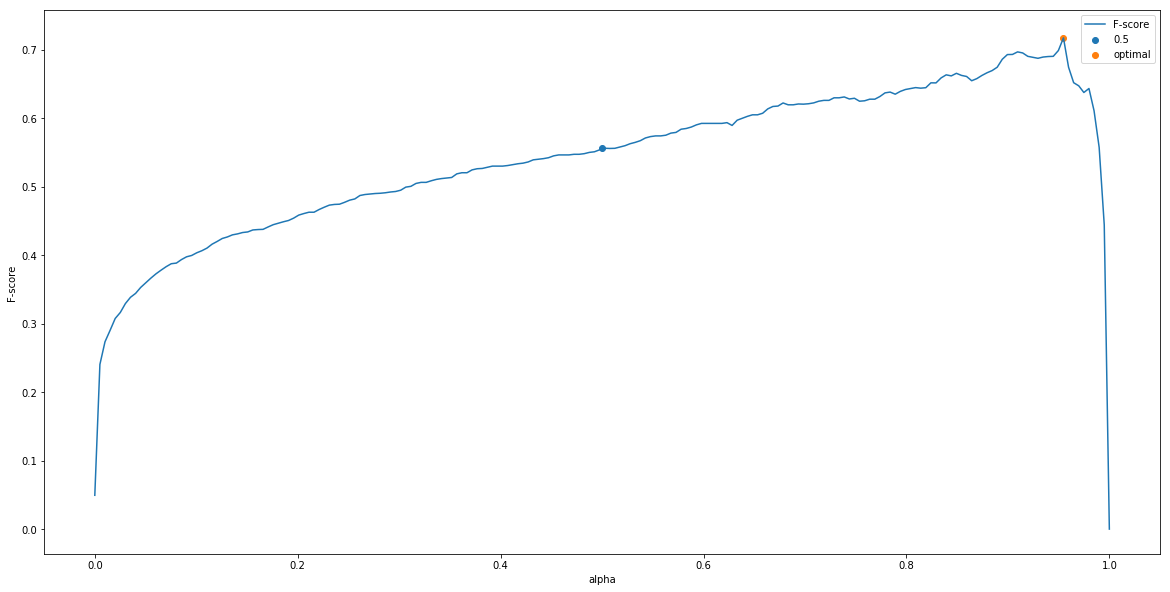

In [155]:
plot(alphas, scores, label='F-score');
scatter(0.5, get_score(0.5, y_unbalanced, y_hat), label='0.5');
scatter(alphas[np.argmax(scores)], np.max(scores), label='optimal');
xlabel('alpha'); ylabel('F-score'); legend();

## Модификация датасета

* Искуственное изменение пропорции меток в датасете
    * **Undersampling** — уменьшение размера доминирующего класса
    * **Oversampling** — увеличение размера минорного класса
* Для работы с несбалансированными выборками существует удобная библиотека [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/index.html)
* Предоставляет большой выбор методов **undersampling**'a и **oversampling**'a
* Имеет **API**, позволяющее встраиваться в **cross_val_predict** и **cross_val_score**    

## Undersampling

Уменьшение размера доминирующего класса
![undersampling](images/under_2.png)

## Undersampling

* Случайное выбрасывание объектов [imblearn.under_sampling.RandomUnderSampler](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler)
* Замена доминирующих объектов на их кластера с помощью **KMeans** [imblearn.under_sampling.ClusterCentroids](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.under_sampling.ClusterCentroids.html#imblearn.under_sampling.ClusterCentroids)
* [Много других](http://contrib.scikit-learn.org/imbalanced-learn/api.html#module-imblearn.under_sampling) способов с их описаниями

## Oversampling

Увеличение размера минорного класса
![oversampling](images/over_2.png)

## Oversampling

* Случайное повторение объектов из минорного класса [imblearn.over_sampling.RandomOverSampler](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler)
* Генерация новых объектов с помощью линейной комбинации существующих [imblearn.under_sampling.SMOTE](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE)
* [Много других](http://contrib.scikit-learn.org/imbalanced-learn/api.html#module-imblearn.over_sampling) способов с их описаниями

## Пример работы с imblearn

In [217]:
clf = pipeline.make_pipeline(over_sampling.SMOTE(), LogisticRegression())
y_hat = cross_val_predict(clf, x_unbalanced, y_unbalanced, cv=cv, method='predict_proba')[:, 1]

## Выбор порога для SMOTE

* Лучший $F = 0.691068$ при $\alpha = 0.452261$

In [218]:
alphas = np.linspace(0, 1, 200)
scores = [get_score(alpha, y_unbalanced, y_hat) for alpha in alphas]

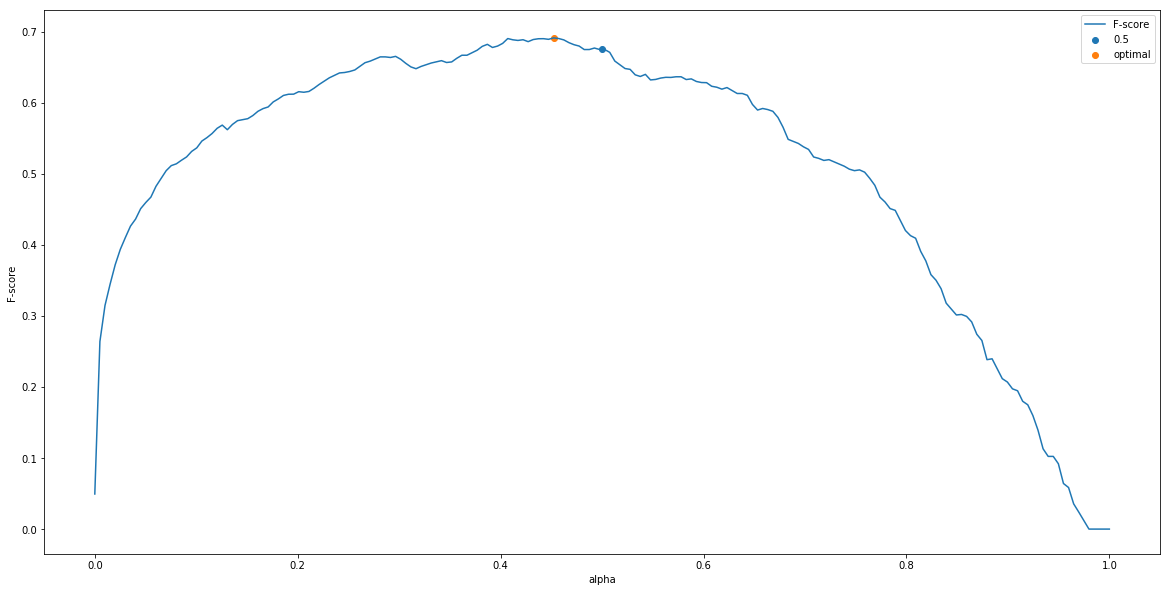

In [220]:
plot(alphas, scores, label='F-score');
scatter(0.5, get_score(0.5, y_unbalanced, y_hat), label='0.5');
scatter(alphas[np.argmax(scores)], np.max(scores), label='optimal');
xlabel('alpha'); ylabel('F-score'); legend();